# Milestone 2 : Project proposal and initial analyses 🍻

<hr style="clear:both">
This notebook was made for the ADA course at EPFL (CS-401). 

Group : BeerADAventure46

**Authors:** \
[Agatha Hunter](https://people.epfl.ch/agatha.hunter)\
[Anne-Valérie Preto](https://people.epfl.ch/anne-valerie.preto)\
[Tristan Carruzzo](https://people.epfl.ch/tristan.carruzzo)\
[Thamin Maurer](https://people.epfl.ch/thamin.maurer)\
[Victor Dubien](https://people.epfl.ch/victor.dubien)


**Supervisor:**\
[Beatriz Borges](https://people.epfl.ch/beatriz.borges)
<hr style="clear:both">



<blockquote>

## Project proposal  📌

**Influence of the serving style on the tasting profile**:

Goal of the project: Use the textual reviews to find for each beer how it was served (either bottle, can or draft) and find how it influences the tasting profile.

Different serving styles may be adopted in different regions or for different types of beer.  The influence of the serving style could influence not only the appearance, but also the aroma, the palate or the taste.
</blockquote>

### Import libraries

In [1]:
from utils import *

pd.set_option('display.max_columns', None)

## 1. Datasets 📂

### 1.1 Import dataset

In [2]:
# Firt time imports : 
# Convert txt to csv (function in the utils.py file)

#ratings = convert_txt_to_csv(input_file='ratings.txt', export=True, file_name='ratings')
#reviews = convert_txt_to_csv(input_file='reviews.txt', export=True, file_name='reviews')

In [3]:
# Files already converted, so we can load them directly

reviews = pd.read_csv(dataset_path + 'reviews.csv')
beers = pd.read_csv(dataset_path + 'beers.csv')
breweries = pd.read_csv(dataset_path + 'breweries.csv')
users = pd.read_csv(dataset_path + 'users.csv')

### 1.2 Initial datasets analysis 🔎

#### 1.2.1 Beers dataset 🍺

In [4]:
display(beers.sample(3))
print('Shape of beers : ', beers.shape)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
81227,90203,SLOambic,2210,Firestone Walker Brewing Co.,American Wild Ale,290,29,4.37,95.0,100.0,5.6,4.379931,NaN,0,NaN
252198,145860,Barrel Aged Swan Song,34315,Hailstorm Brewing Co.,Belgian Strong Dark Ale,14,0,4.07,86.0,NaN,10.4,4.065714,NaN,0,NaN
184599,251277,Tropical Paradise,40035,Lupulin Brewing,American Porter,2,0,3.63,NaN,NaN,NaN,3.625000,NaN,0,NaN


Shape of beers :  (280823, 15)


In [5]:
# print the number of beers id and beer name
print('Number of different beers id:', len(beers.beer_id.unique()))
print('Number of different beers name:', len(beers.beer_name.unique()))

Number of different beers id: 280823
Number of different beers name: 236209


<blockquote>

**Initial comments about the dataset**

-Some beers have the same name! In order to avoid confusion, we will drop the column beer_name (and brewery_name) from the dataset.

-As we will not use the RateBeer dataset, we can also drop the column nbr_matched_valid_ratings and avg_matched_valid_ratings.  

-The column bros_score only reflect the ratings from the two creators of the website, so we can also drop it.  

-ba_score represents the percentage (rounded to the tenth for depth) of raters who gave the beer a 3.75 or higher as long as the beers as at least 10 ratings.

</blockquote>

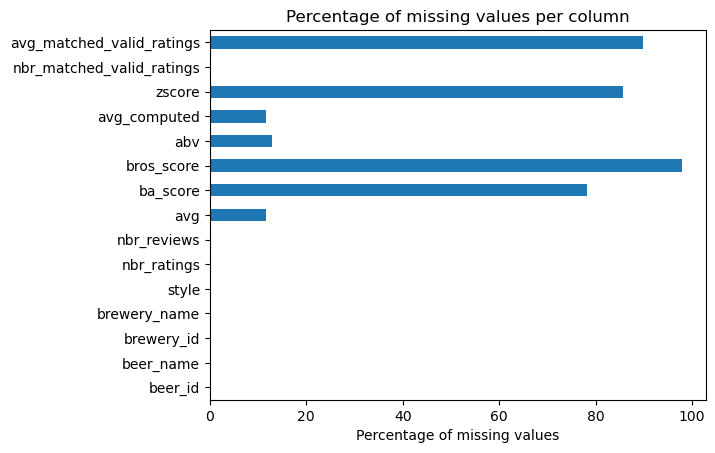

avg                      : 32829 missing values (11.69%)
ba_score                 : 219623 missing values (78.21%)
bros_score               : 275121 missing values (97.97%)
abv                      : 36024 missing values (12.83%)
avg_computed             : 32841 missing values (11.69%)
zscore                   : 240538 missing values (85.65%)
avg_matched_valid_ratings: 252551 missing values (89.93%)


In [6]:
show_missing(beers)

<blockquote>

**More comments about the dataset**

We see that more than 80% of the beers do not have a z-score value. It is something we will need to take into account when we verify if our final dataset if representative. To make sure our final data has the same data distribution, we will re compute the z_score and compare it to this one, or one computed from the initial database.

For now, we can drop this column alongside avg_computed and compute them manually later if needed from the reviews dataset. 

80% of the beers have no ba_score value, so we can also drop it and compute it later if needed.

The other columns with NaN such as avg_matched_valid_ratings, avg_computed or bros_score are not usefull in our analysis since we only look at the BeerAdvocate reviews.

However, the abv, which represents the alcohol percentage in a beer, is missing for approximately 12%.

</blockquote>

In [7]:
beers_filtered = beers.drop(columns=['beer_name', 
                            'brewery_name',
                            'bros_score',
                            'ba_score',
                            'nbr_matched_valid_ratings',
                            'avg_matched_valid_ratings',
                            'zscore',
                            'avg_computed']).copy(deep=True)

beers_filtered.rename(columns={'nbr_ratings': 'beer_nbr_ratings',
                               'nbr_reviews': 'beer_nbr_reviews'}, inplace=True)

In [8]:
beers_filtered.sample(3)

,beer_id,brewery_id,style,beer_nbr_ratings,beer_nbr_reviews,avg,abv
94999,154879,199,American Porter,2,0,3.64,5.6
11833,182649,41566,American Double / Imperial IPA,16,3,3.64,9.0
112665,117326,28609,Saison / Farmhouse Ale,47,2,3.46,8.5


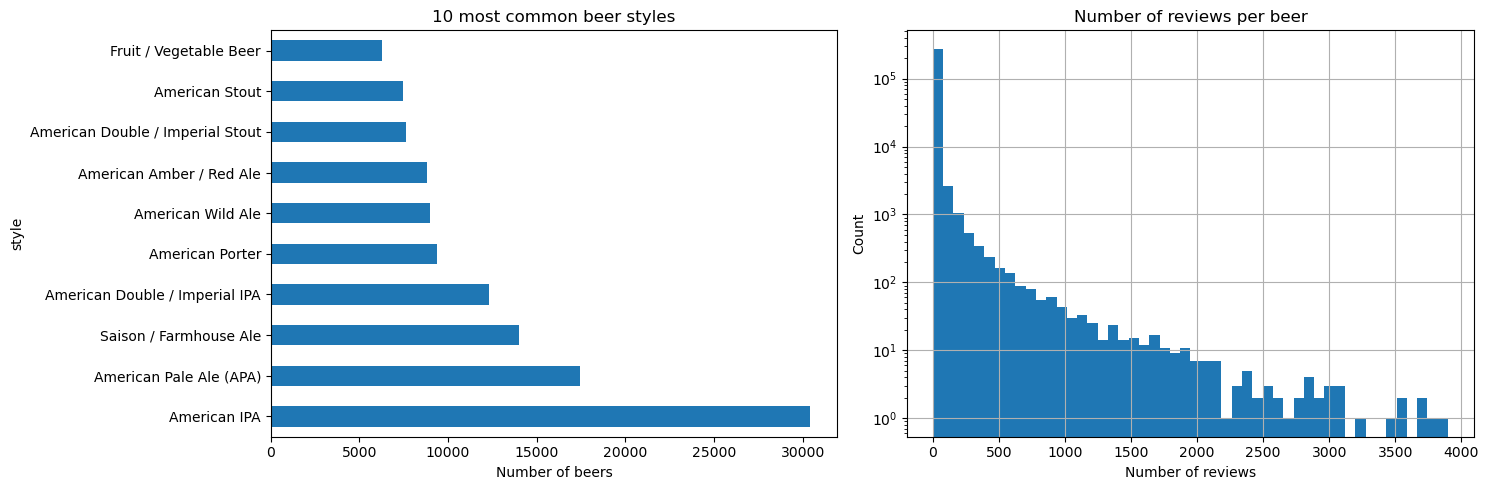

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
beers_filtered['style'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common beer styles')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
beers_filtered['beer_nbr_reviews'].hist(bins=50,log=True)
plt.title('Number of reviews per beer')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.tight_layout()
plt.show()

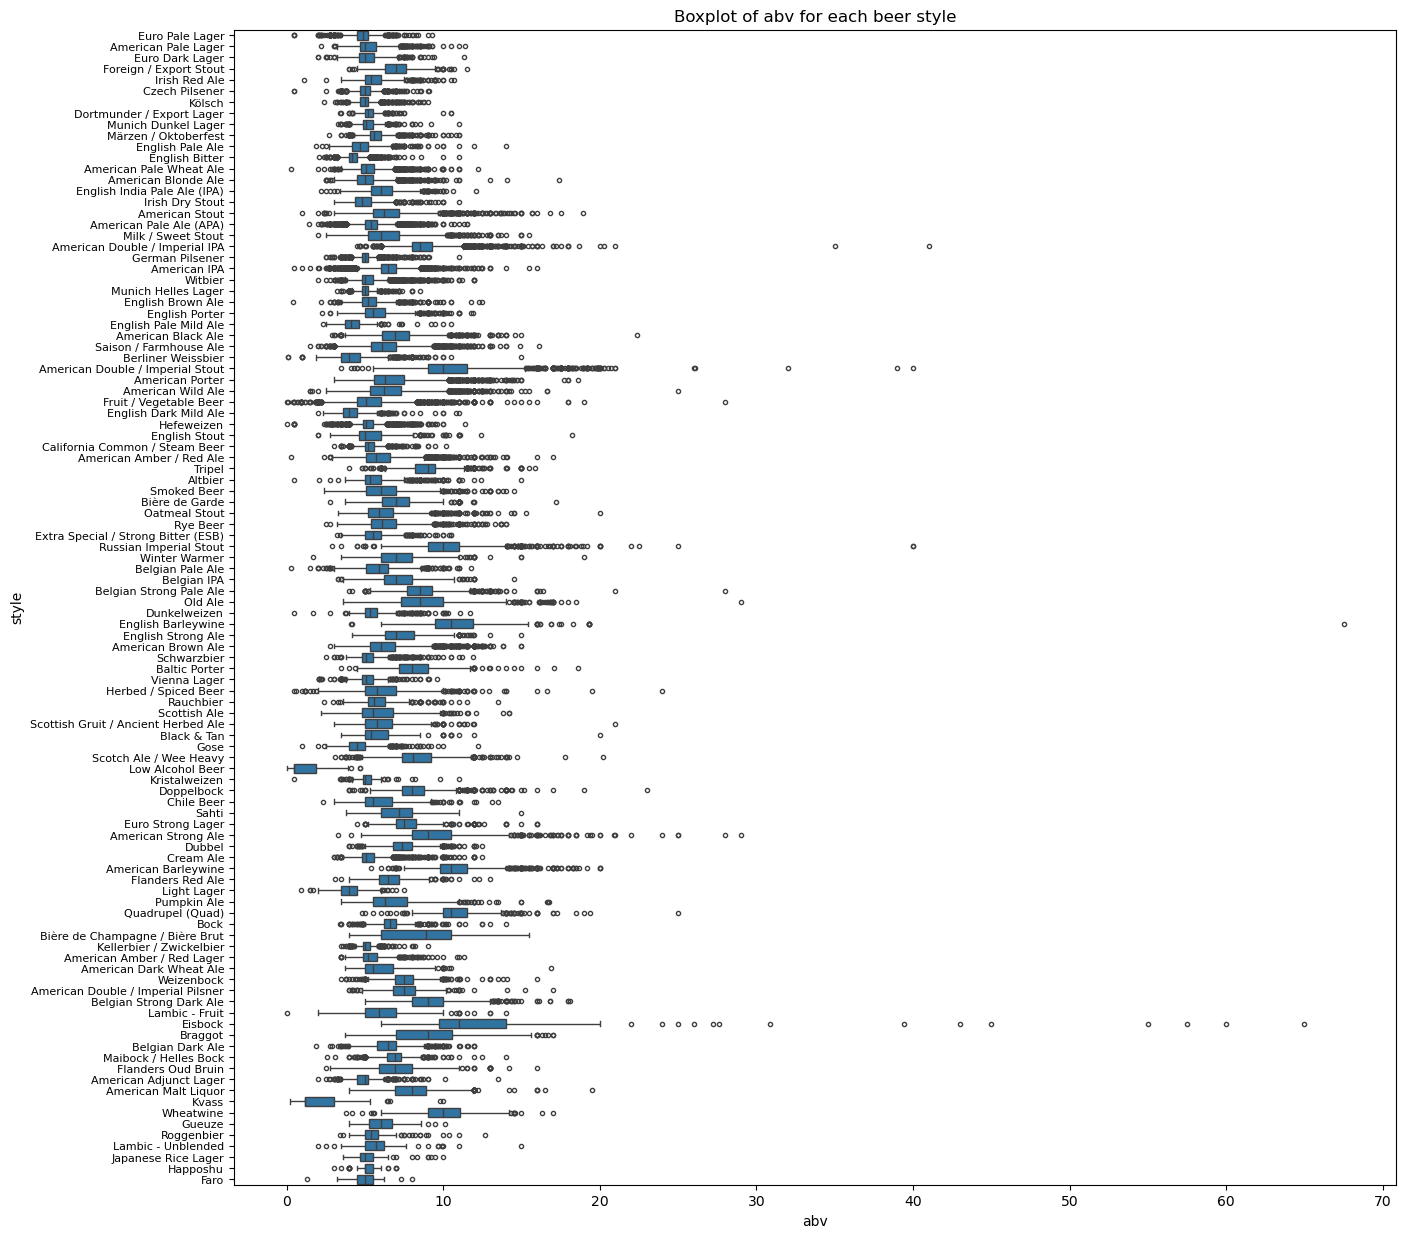

In [10]:
# show boxplot of abv for each beer style
plt.figure(figsize=(15, 15))
sns.boxplot(y='style', x='abv', data=beers_filtered, fliersize=3)
plt.yticks(fontsize=8)
plt.title('Boxplot of abv for each beer style')
plt.show()

In [11]:
# group the beers by style and compute the median of abv for each style
median_abv_by_style = beers_filtered.groupby('style')['abv'].median()
# display(median_abv_by_style.sample(3))

# fill the missing abv values with the median of abv for the style of each beer
beers_filtered['abv'] = beers_filtered.apply(lambda x: median_abv_by_style[x['style']] if pd.isna(x['abv']) else x['abv'], axis=1)

In [12]:
beers_filtered.describe()

,beer_id,brewery_id,beer_nbr_ratings,beer_nbr_reviews,avg,abv
count,280823.000000,280823.000000,280823.000000,280823.000000,247994.000000,280823.000000
mean,148556.817141,21335.895860,29.887267,9.221417,3.721034,6.434481
std,84307.593397,15385.715656,231.010063,68.866445,0.476003,1.984850
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,76513.500000,3835.000000,1.000000,0.000000,3.500000,5.000000
50%,148867.000000,24075.000000,2.000000,1.000000,3.780000,6.000000
75%,221817.500000,33960.000000,8.000000,2.000000,4.010000,7.300000
max,293296.000000,49817.000000,16509.000000,3899.000000,5.000000,67.500000


<blockquote>

We are left with a dataset containing 280823 beers. We are only missing some values for avg as some beers do not have any ratings/reviews. They will be removed later when merging with the reviews dataset anyway.

</blockquote>

#### 1.2.2 Breweries dataset 🏭

In [13]:
display(breweries.sample(3))
print('Shape of breweries : ', breweries.shape)

,id,location,name,nbr_beers
13056,47498,"United States, Michigan",Downey Brewing Company,13
14272,43747,"United States, Utah",Park City Brewery,7
6843,42800,Czech Republic,Pivovar U Dobřenských,2


Shape of breweries :  (16758, 4)


In [14]:
# show the missing values
show_missing(breweries)

There are no missing values in this dataset.


<blockquote>

This dataset has no missing values, we will simply rename the columns and drop the brewery name.

</blockquote>

In [15]:
breweries_filtered = breweries.drop(columns=['name']).copy(deep=True)

breweries_filtered.rename(columns={'id':'brewery_id',
                                   'location':'brewery_location',
                                   'nbr_beers':'brewery_nbr_beers'}, inplace=True)

In [16]:
breweries_filtered.sample(3)

,brewery_id,brewery_location,brewery_nbr_beers
3918,921,Germany,13
16374,152,"United Kingdom, England",17
14954,9903,France,1


In [17]:
# Some breweries have weird location values, they contain google maps links. All the breweries with a weird location value are in the US.
print('Number of breweries with a weird location value:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]))

# for loc in breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_location'].unique():
#     print(loc) # print the strange values

Number of breweries with a weird location value: 35


In [18]:
# manually adding the location for those 35 breweries

#obtain the brewery_id of the 35 breweries
strange_id = breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_id'].unique()

# create a dic with the brewery_id as key and unknwon as value
dic = {}
for i in strange_id:
    dic[i] = 'unknown'
    
# function that takes as input the brewery_id and a location and change the location of the brewery with the given id in the dictionary dic 
def change_location(brewery_id, us_state):
    location = 'United States, ' + us_state
    dic[brewery_id] = location

In [19]:
# take the first element of dic that has value unknown and print its location
for key, value in dic.items():
    if value == 'unknown':
        print('Brewery id:', key)
        print('Strange location:',breweries_filtered[breweries_filtered['brewery_id'] == key]['brewery_location'].values[0])        
        break

Brewery id: 2434
Strange location: United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bluecorncafe.com" target="_blank">bluecorncafe.com


In [20]:
#Changing the location in dic

change_location(brewery_id=2434,us_state='New Mexico')
change_location(brewery_id=2730,us_state='Wisconsin')
change_location(brewery_id=1551,us_state='California')
change_location(brewery_id=1552,us_state='Michigan')
change_location(brewery_id=2710,us_state='California')
change_location(brewery_id=3681,us_state='Ohio')
change_location(brewery_id=2413,us_state='California')
change_location(brewery_id=1793,us_state='Virginia')
change_location(brewery_id=6045,us_state='New Jersey')
change_location(brewery_id=2776,us_state='New York')
change_location(brewery_id=1751,us_state='Texas')
change_location(brewery_id=1554,us_state='Georgia')
change_location(brewery_id=1961,us_state='Maine')
change_location(brewery_id=4927,us_state='South Carolina')
change_location(brewery_id=23973,us_state='Maine')
change_location(brewery_id=2512,us_state='California')
change_location(brewery_id=6416,us_state='New Jersey')
change_location(brewery_id=2104,us_state='Oregon')
change_location(brewery_id=3079,us_state='Washington')
change_location(brewery_id=2410,us_state='Michigan')
change_location(brewery_id=1931,us_state='Ohio')
change_location(brewery_id=1553,us_state='Maine')
change_location(brewery_id=1550,us_state='Colorado')
change_location(brewery_id=32764,us_state='Illinois')
change_location(brewery_id=8451,us_state='Wyoming')
change_location(brewery_id=5114,us_state='California')
change_location(brewery_id=1802,us_state='North Carolina')
change_location(brewery_id=1819,us_state='Minnesota')
change_location(brewery_id=200,us_state='California')
change_location(brewery_id=918,us_state='Florida')
change_location(brewery_id=4343,us_state='California')
change_location(brewery_id=9765,us_state='New York')
change_location(brewery_id=1927,us_state='Colorado')
change_location(brewery_id=28908,us_state='Utah')
change_location(brewery_id=70,us_state='Oregon')
change_location(brewery_id=1567,us_state='Hawaii')

In [21]:
# change the location of the breweries in the breweries_filtered dataframe
for key, value in dic.items():
    breweries_filtered.loc[breweries_filtered['brewery_id'] == key, 'brewery_location'] = value

In [22]:
# how many different locations are there that contain United States
print('Number of different locations that contain United States:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('United States')]['brewery_location'].unique()))

Number of different locations that contain United States: 50


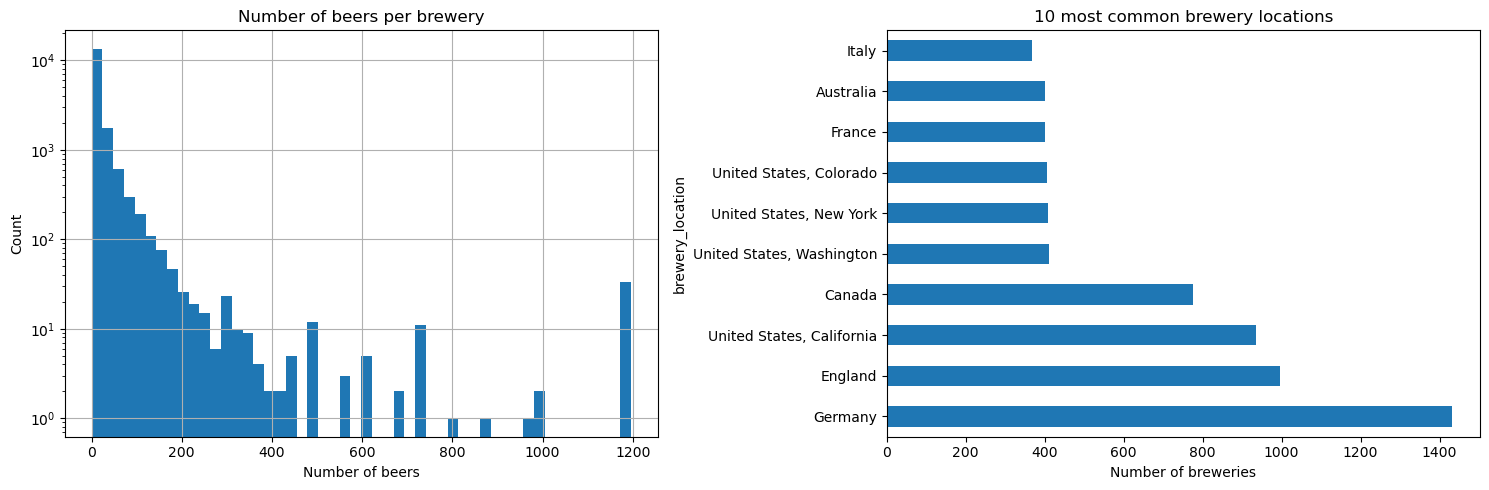

In [23]:
# Representation of beers per brewery and most common brewery locations
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
breweries_filtered['brewery_nbr_beers'].hist(bins=50, log=True)
plt.title('Number of beers per brewery')
plt.ylabel('Count')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
breweries_filtered['brewery_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common brewery locations')
plt.xlabel('Number of breweries')
plt.tight_layout()
plt.show()

#### 1.2.3 Users dataset 👤

In [24]:
display(users.sample(3))
print('Shape of users : ', users.shape)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
25194,1,1,stosh.11571,Stosh,1.102504e+09,"United States, Pennsylvania"
71268,18,0,scott_hatcher.908338,Scott_Hatcher,1.418555e+09,"United States, California"
45662,14,14,morningbeer.423125,MorningBeer,1.265195e+09,"United States, Iowa"


Shape of users :  (153704, 6)


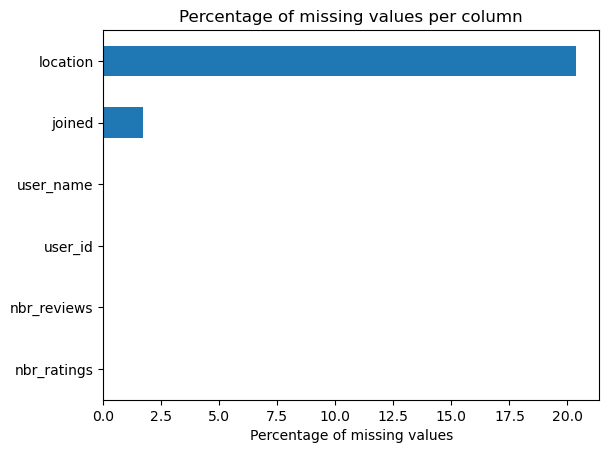

user_name                :     1 missing values (0.00%)
joined                   :  2652 missing values (1.73%)
location                 : 31279 missing values (20.35%)


In [25]:
show_missing(users)

<blockquote>

We are only missing information about when the user joined the website and locations. (and 1 username, which we drop anyway)

</blockquote>

In [26]:
users_filtered = users.drop(columns=['user_name']).copy(deep=True)

users_filtered.rename(columns={'nbr_ratings':'user_nbr_ratings',
                               'nbr_reviews':'user_nbr_reviews',
                               'joined':'user_joined',
                               'location':'user_location'}, inplace=True)

users_filtered.sample(3)

,user_nbr_ratings,user_nbr_reviews,user_id,user_joined,user_location
122880,1,0,jim_hatch.737574,1.371550e+09,NaN
139301,1,0,rodney_bassett.874898,1.412762e+09,NaN
137653,4,0,finman1017.920105,1.420369e+09,"United States, Pennsylvania"


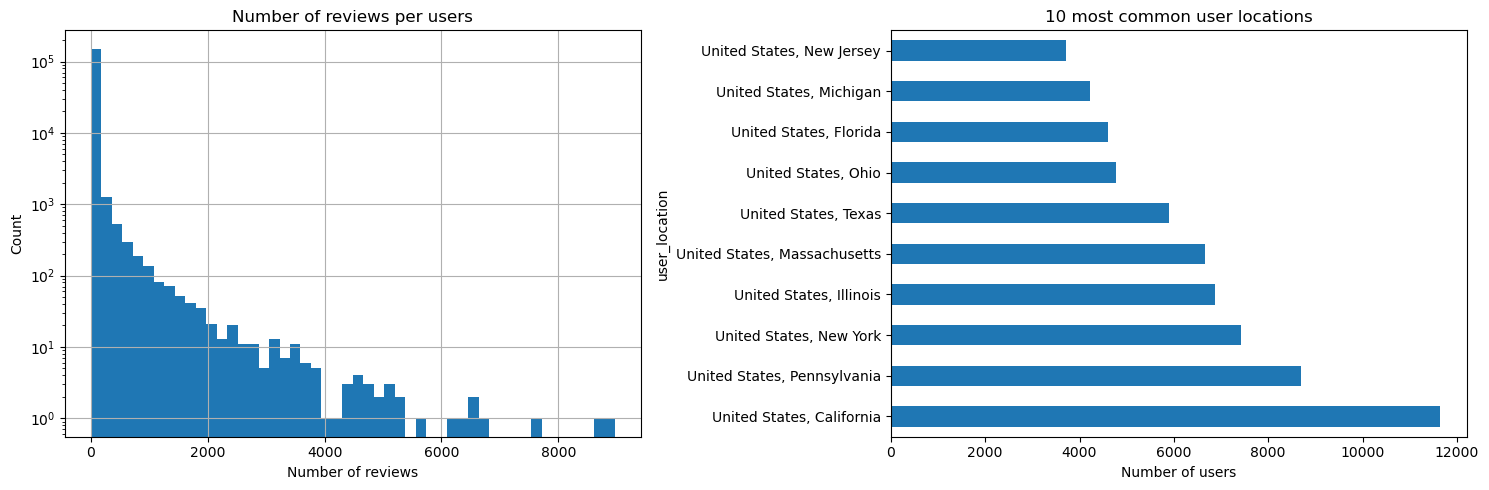

In [27]:
# Representation of reviews per user and most common user locations
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
users_filtered['user_nbr_reviews'].hist(bins=50, log=True)
plt.title('Number of reviews per users')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.subplot(1, 2, 2)
users_filtered['user_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common user locations')
plt.xlabel('Number of users')
plt.tight_layout()
plt.show()

<blockquote>

We observe that many users have no reviews at all, they will be removed from the dataset when merging. Also, the 10 most common user location are all in the US.

</blockquote>

#### 1.2.4 Reviews dataset 📝

In [28]:
display(reviews.sample(3))
print('Shape of reviews : ', reviews.shape)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
25360,The Red MacGregor,3329,Orkney Brewery,118,Scottish Ale,4.0,1224669600,JamesS,jamess.156552,3.5,3.0,3.0,4.0,3.50,3.53,Pours a very nice dark amber/copper color with...
849114,Ruination Double IPA 2.0,168971,Stone Brewing,147,American Double / Imperial IPA,8.5,1436004000,TheBlueWaffle,thebluewaffle.639626,4.0,4.0,4.0,4.0,4.25,4.05,I'm not sure if changing the original recipe w...
2397414,Brugse Zot,25130,Huisbrouwerij De Halve Maan,268,Belgian Pale Ale,6.0,1221904800,Regenpak,regenpak.11554,3.0,4.0,4.0,4.0,4.00,3.94,I got this beer as a present in a huge decorat...


Shape of reviews :  (2589586, 16)


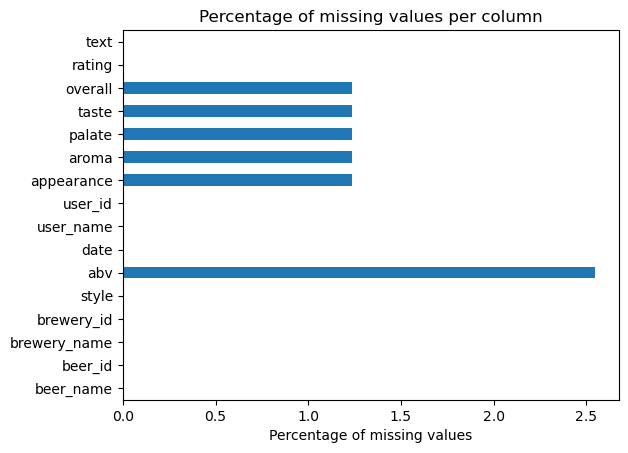

abv                      : 65983 missing values (2.55%)
user_name                :     3 missing values (0.00%)
appearance               : 32009 missing values (1.24%)
aroma                    : 32009 missing values (1.24%)
palate                   : 32009 missing values (1.24%)
taste                    : 32009 missing values (1.24%)
overall                  : 32009 missing values (1.24%)
text                     :     2 missing values (0.00%)


In [29]:
show_missing(reviews)

In [30]:
# making sure that all the missing values of the rating aspects are in the same rows

# print the number of rows that contains a NaN value for each column ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of rows with NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews[reviews[col].isna()]))
    
print()
# print the number of rows that contains a NaN value for all the rating aspects
missing_values = reviews[['overall', 'taste', 'palate', 'aroma', 'appearance']].isna()
missing_values['all_missing'] = missing_values.all(axis=1)
print(missing_values['all_missing'].value_counts())

Number of rows with NaN values for each column :
overall : 32009
taste : 32009
palate : 32009
aroma : 32009
appearance : 32009

all_missing
False    2557577
True       32009
Name: count, dtype: int64


<blockquote>

All the missing values are in the same rows, and they represent less than 1.5% of the dataset. We can drop them.

</blockquote>

In [31]:
# remove the columns that are not useful for our analysis
reviews_filtered = reviews.drop(columns=['user_name', 'beer_name', 'brewery_name']).copy(deep=True)

# remove the column abv because we have the information in the beers dataframe
reviews_filtered.drop(columns=['abv'], inplace=True)

#remove rows in reviews_filtered that have all_missing True in missing_values
reviews_filtered = reviews_filtered[~missing_values['all_missing']].copy(deep=True)

#remove the two reviews that have no text
reviews_filtered = reviews_filtered[~reviews_filtered['text'].isna()].copy(deep=True)

display(reviews_filtered.sample(3))
print('Shape of reviews_filtered : ', reviews_filtered.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text
1014009,54904,35,Czech Pilsener,1333533600,sawdog505.446692,4.00,4.00,4.0,4.50,4.00,4.20,Poured into a 13 oz tulip. Pours a light straw...
2142006,21082,2641,American Double / Imperial IPA,1391943600,reidrover.1347,4.25,4.25,4.0,4.25,4.00,4.18,22 oz bomber bought at Roth’s Sunnyslope Marke...
681057,276,140,American Pale Ale (APA),1470391200,thebeers.861134,3.75,4.00,4.0,4.25,4.25,4.14,"Drank this one (okay, two) from the bottle. S..."


Shape of reviews_filtered :  (2557575, 12)


In [32]:
show_missing(reviews_filtered)

There are no missing values in this dataset.


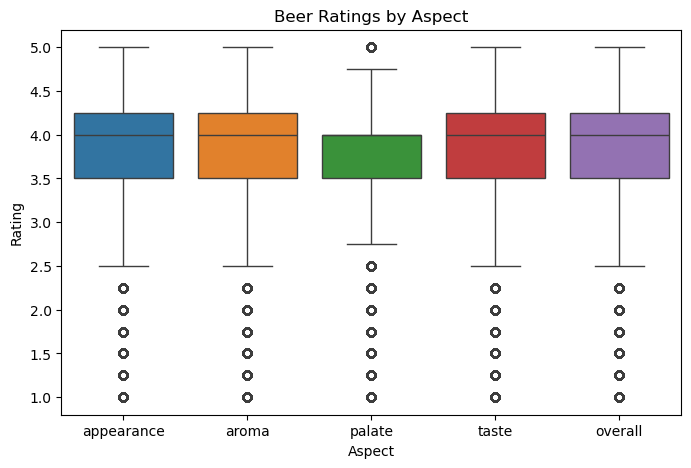

In [33]:
# show boxplot for each rating column, appearance, aroma, palate, taste and overall

plt.figure(figsize=(8, 5))
sns.boxplot(data=reviews_filtered[['appearance', 'aroma', 'palate', 'taste', 'overall']])
plt.title('Beer Ratings by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.show()

### 1.3 Merge datasets 🔗

In [34]:
# Merge reviews with users and beers and breweries
df_merged = reviews_filtered.merge(beers_filtered, how='left', on=['beer_id', 'brewery_id', 'style'])
df_merged = df_merged.merge(users_filtered, how='left', on='user_id')
df_merged = df_merged.merge(breweries_filtered, how='left', on='brewery_id')

display(df_merged.sample(1))
print('Shape of df_merged : ', df_merged.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
9457,36,24,Scotch Ale / Wee Heavy,1061805600,royalt.2560,4.0,4.5,4.0,4.5,4.5,4.42,Appearance  Dark brown body with a good head ...,1069,618,4.16,7.2,1985,1985,1.059559e+09,"United States, Ohio",Scotland,11


Shape of df_merged :  (2557575, 22)


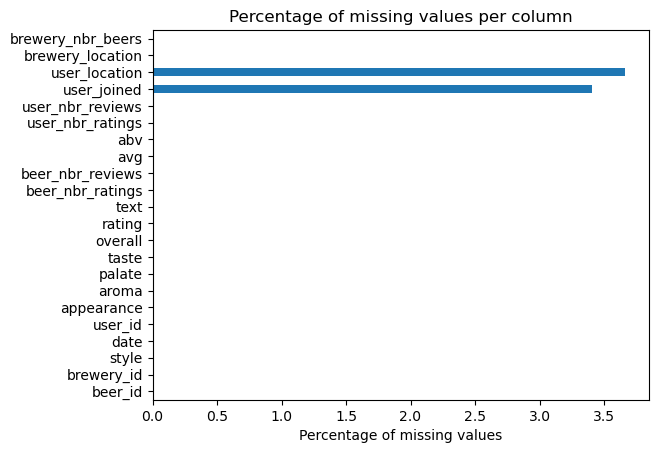

user_joined              : 87150 missing values (3.41%)
user_location            : 93668 missing values (3.66%)


In [35]:
show_missing(df_merged)

In [36]:
# We can replace missing user_joined values with the date of the first review of the user
df_merged['first_review'] = df_merged.groupby('user_id')['date'].transform('min')
df_merged['user_joined'] = df_merged['user_joined'].fillna(df_merged['first_review'])
df_merged.drop(columns=['first_review'], inplace=True)

> We have a complete dataset. Only information about the location of users is missing for 3.66% reviews.

In [37]:
# Save to csv
# df_merged.to_csv(dataset_path + 'BeerAdvocateMerged.csv', index=False)

## 2. Data enrichment 🍺

In [38]:
df = pd.read_csv(dataset_path + 'BeerAdvocateMerged.csv')

In [39]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
886457,78377,23200,American Double / Imperial IPA,1356692400,alieniloquium.277522,3.0,4.0,4.0,4.0,3.5,3.84,650 mL bottle to a snifter. Reviewed from note...,2233,373,4.25,11.25,4377,4376,1.229425e+09,"United States, Florida","United States, California",100
1318723,1252,29,Bock,1087466400,brewdlyhooked13.863,4.5,2.0,2.5,2.5,3.5,2.70,"Appearance - pours a dark amber with a thin, s...",1823,687,2.87,5.20,1622,1609,1.033985e+09,"United States, Ohio","United States, Missouri",185
2501085,857,313,Dubbel,1337853600,zac16125.420167,4.0,4.5,5.0,4.5,5.0,4.62,33cL bottle poured into a chaliceBest before d...,2166,820,4.48,8.00,1010,981,1.264504e+09,"United States, South Carolina",Belgium,7


Shape of df :  (2557575, 22)


### 2.1 Serving style 🍾🥤🚰

#### 2.1.1 naive approach

>Since our goal is to look at the influence of the serving style, we need to know how each beer was served.   
A first idea was to use a naive approach. We only look at whether a word specific to as service style has been used. 

In [40]:
def serving_type_naive(df):
    """
    Create a new column serving_type_naive that contains the serving type of the beer using the naive approach.
    """
    # Create 3 different columns according to the text review, "bottle", "can", "draft"
    bottle = {'bottle', 'bottled', 'bottles', 'bomber'}
    can = {'can', 'canned', 'cans', }
    draft = {'draft', 'draught', 'tap', 'taps', 'cask', 'growler', 'keg'}
    
    # Create different columns if review text contains the word
    df['bottle'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in bottle))
    df['can'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in can))
    df['draft'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in draft))
    
    # if there are more than one true or no true, set the value to 'unknown'
    df.loc[df[['bottle', 'can', 'draft']].sum(axis=1) != 1, 'serving_type_naive'] = 'unknown'

    # drop the columns bottle, can and draft
    df.drop(['bottle', 'can', 'draft'], axis=1, inplace=True)
    return df

#### 2.1.2 Similarity 🍾🥤🚰

> Compute the similarity between the reviews and a list of words specific to each serving style. The list is more exhaustive in this method, using words such as aluminium or cork for can and bottle respectively. Select the serving style with the highest similarity.

In [41]:
def serving_type_sim(df, word_bottle='data/bottle.txt', word_can='data/can.txt', word_draft='data/draft.txt', threshold=0.5):
    """
    Compute the cosine similarity between the review text and the list of words for each serving type. Select the serving type with the highest similarity score.
    """
    # Read the list of words from the text file
    with open(word_can, 'r') as file:
        word_can = file.read().splitlines()

    with open(word_bottle, 'r') as file:
        word_bottle = file.read().splitlines()

    with open(word_draft, 'r') as file:
        word_draft = file.read().splitlines()

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')

    # Transform the review and words list using TF-IDF
    tfidf_matrix = vectorizer.fit_transform(df['text'].astype(str))

    can_vector = vectorizer.transform([" ".join(word_can)])
    bottle_vector = vectorizer.transform([" ".join(word_bottle)])
    draft_vector = vectorizer.transform([" ".join(word_draft)])

    # Calculate the cosine similarity
    cosine_sim_can = cosine_similarity(tfidf_matrix, can_vector)
    cosine_sim_bottle = cosine_similarity(tfidf_matrix, bottle_vector)
    cosine_sim_draft = cosine_similarity(tfidf_matrix, draft_vector)

    # Get the maximum similarity score and corresponding serving type
    max_sim = np.maximum.reduce([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft])
    serving_type = np.where(max_sim >= threshold, np.array(['bottle', 'can', 'draft'])[np.argmax([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft], axis=0)], 'unknown')

    # Add the serving_type_sim column to the dataframe
    df['serving_type_sim'] = serving_type

    return df

#### 2.1.3 Rule-based approach 🍾🥤🚰

> Homemade algorithm used to find the serving type using a rule-based approach.

In [42]:
nlp = spacy.load("en_core_web_sm")

def differentiate_can(doc):
    """
    Differentiate between the noun and verb form of the word "can" in the review text.
    """
    verbes_nom = []
    for token in doc:
        if token.text.lower() == "can" and any(t.dep_ == "aux" for t in token.head.children):
            verbes_nom.append("verb")
        elif token.text.lower() == "can":
            verbes_nom.append("noun")

    return verbes_nom

def remove_conditional(doc):
    """
    Remove parts of the review text that are in the conditional form.
    """
    modified_tokens = []
    remove_sentence = False

    for sent in doc.sents:
        for token in sent:
            if remove_sentence:
                continue
            if token.text.lower() in {"would", "could", "'d"}:
                subtree = [t.text for t in token.subtree]
                modified_tokens.extend(subtree[:-1])
                remove_sentence = True
            else:
                modified_tokens.append(token.text)

    modified_text = " ".join(modified_tokens)

    return nlp(modified_text)

def extract_serving_style(review):
    """
    Return the serving style of the beer using the rule-based approach.
    """
    bottle = {'bottle', 'bottled', 'bottles', 'bomber'}
    can = {'can', 'canned', 'cans'}
    draft = {'draft', 'draught', 'tap', 'taps', 'cask', 'growler'}

    # modified_doc = remove_conditional(nlp(review))
    modified_doc = nlp(review)

    serving_styles = set()

    if any(word in modified_doc.text.lower() for word in bottle):
        serving_styles.add("bottle")
    if any(word in modified_doc.text.lower() for word in can) and "noun" in differentiate_can(modified_doc):
        serving_styles.add("can")
    if any(word in modified_doc.text.lower() for word in draft):
        serving_styles.add("draft")

    serving_style = serving_styles.pop() if len(serving_styles) == 1 else 'unknown'

    return serving_style

def process_row(row):
    serving_style = extract_serving_style(row.text)
    return serving_style

def serving_type_rulebased(df):
    # Number of threads to run in parallel (adjust based on your system)
    num_threads = 6
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Apply the function in parallel to each row of the DataFrame
        results = list(tqdm(executor.map(process_row, df.itertuples(index=False)), total=len(df)))

    # Add the results to the DataFrame
    df['serving_type_rulebased'] = results
    
    return df

#### 2.1.4 Test on sample df

<blockquote>

To test which method performed best to retrieve the serving style of a beer, we manually labelled 250 reviews sampled randomly on the merged dataset. Each member of the group labelled 50 reviews as "unknown", "draft", "can" or "bottle".<break>


The goal was to learn more about the reviews, and find pattern that could help us for the rule-based method. After a few reviews, we added some words related to draft for example.


</blockquote>

##### 2.1.4.1 Obtain a df with true serving types

In [43]:
#250 reviews for function evaluation (manually labelled)
df_eval = df.sample(n=250, random_state=46).copy(deep=True)
df_eval['true_serving_type'] = 'not_set'

In [44]:
df_eval['true_serving_type'].value_counts()

true_serving_type
not_set    250
Name: count, dtype: int64

In [45]:
# Function used to display a review and label the serving style
#idx = display_review(df_eval)
#df_eval = update_review_serving_type(df_eval, idx)

In [46]:
# df_eval.to_csv('data/BeerAdvocateEval.csv', index=False)
df_eval = pd.read_csv('data/BeerAdvocateEval.csv')

In [47]:
# Distribution of the serving types in the evaluation set
df_eval['true_serving_type'].value_counts()

true_serving_type
unknown    141
bottle      82
draft       20
can          7
Name: count, dtype: int64

##### 2.1.4.2 Call each function and evaluate (time and accuracy)

In [48]:
display(df_eval.sample(3))

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,true_serving_type
210,49664,9629,Wheatwine,1462874400,masonz223.1011101,4.25,4.25,4.0,3.75,3.75,3.93,Smell: orange juice white grape sweet fruit wi...,521,205,3.96,10.0,274,235,1.436350e+09,"United States, Michigan","United States, Michigan",449,unknown
190,42836,63,American Porter,1217498400,slatetank.102045,4.00,4.50,4.0,4.50,4.00,4.32,I appreciated johnmichaelsen sharing this with...,358,282,4.32,11.0,4533,3507,1.160474e+09,"United States, Pennsylvania","United States, Oregon",431,bottle
200,20134,3517,Euro Pale Lager,1310119200,lackenhauser.1153,4.00,3.00,4.0,3.50,4.00,3.56,Decent golden color with a great foamy head th...,140,78,3.13,5.0,1341,1278,1.039604e+09,"United States, Maryland",Belgium,63,unknown


In [49]:
t1 = time.time()
df_eval = serving_type_naive(df_eval)
t_naive = time.time() - t1
print(f"Naive method took {t_naive} seconds")

print('Naive method accuracy:', compute_accuracy(df_eval['serving_type_naive'], df_eval['true_serving_type']))

Naive method took 0.015743255615234375 seconds
correct_count : 113, total_count : 250
Naive method accuracy: 0.452


/var/folders/xk/b4p7r0yj03xf8vy7mf1kwrzm0000gn/T/ipykernel_59495/179222769.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df[['bottle', 'can', 'draft']].sum(axis=1) != 1, 'serving_type_naive'] = 'unknown'


In [50]:
t1 = time.time()
df_eval = serving_type_sim(df_eval)
t_sim = time.time() - t1
print(f"Similarity method took {t_sim} seconds")

print('Similarity method accuracy:', compute_accuracy(df_eval['serving_type_sim'], df_eval['true_serving_type']))

Similarity method took 0.0750131607055664 seconds
correct_count : 141, total_count : 250
Similarity method accuracy: 0.564


In [51]:
t1 = time.time()
df_eval = serving_type_rulebased(df_eval)
t_rulebased = time.time() - t1
print(f"Rulebased method took {t_rulebased} seconds")

print('Rulebased method accuracy:', compute_accuracy(df_eval['serving_type_rulebased'], df_eval['true_serving_type']))

100%|██████████| 250/250 [00:02<00:00, 103.47it/s]

Rulebased method took 2.570781946182251 seconds
correct_count : 224, total_count : 250
Rulebased method accuracy: 0.896


In [52]:
#print one random misidentified review
df_misclassified = df_eval[df_eval['serving_type_rulebased'] != df_eval['true_serving_type']].copy(deep=True)
for index, row in df_misclassified.sample(1).iterrows():
    print(f"Review {index}:\n{row['text']}\nRule-based serving type: {row['serving_type_rulebased']}\nTrue serving type: {row['true_serving_type']}\n")

Review 62:
This is another beer that I tried at a small local beer tasting last night.It poured an amber-copper color, which exhibited a slight milky like cloudiness. Not much of a head except for a small ring like bubbly head that was off-white in color.Aromas were of a fruity offering, mixed with sweet smelling malts and some fresh floral whiffs at times.A smooth introduction to a solid tasting beer, never overpowering  just very tasty and quite drinkable. Fruity with caramel hints in the middle and a floral finish that allows the hops loose in the lingering crisp finish.Mouthfeel was above average but this aided the Drinkability, which I found to be in the very quaffable category. Served lightly chilled, it soon warmed up in the crowded room, but this only helped to accentuate the nose and flavors.Overall: I really enjoyed this, and I will certainly be keeping an eye out for a bottle of this to remind myself how good this beer was, and if nothing else but to produce a more thorou

> It is quite clear that the rulebased method is the best one. It takes longer to run, but the accuracy gain is worth it. We will use this method to classify the reviews between the 3 serving styles.

In [53]:
# Classification of serving type on the whole dataset
#### 8h run-time
# df = serving_type_rulebased(df)
df = pd.read_csv(dataset_path + 'BA_classified.csv')

In [54]:
df.sample(3)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type_rulebased
308502,712,252,Munich Helles Lager,1382263200,mayerale.730940,4.00,4.00,4.25,4.5,4.5,4.33,Pint bottle poured into a mug.A: Pours a golde...,2306,903,4.03,5.1,47,4,1.367489e+09,"United States, Kansas",Germany,24,bottle
2038247,21822,1199,Russian Imperial Stout,1487156400,jakescully.1079612,4.25,4.25,4.50,4.5,4.5,4.43,Poured the 12oz bottle into a mugGreat Russian...,7861,1899,4.34,10.5,248,154,1.456830e+09,NaN,"United States, Michigan",399,bottle
333809,49425,10029,American Adjunct Lager,1240826400,laituegonflable.61323,3.00,1.50,2.50,2.0,2.5,2.09,"Pours a golden amber colour, fair head but doe...",4,2,2.07,2.7,1942,1942,1.138014e+09,Australia,Australia,9,unknown


### 2.2 Data filtering 🧹
Since our analysis will be focused on the serving style, we will remove all reviews where no serving style was identified. 

<div class="alert alert-block alert-warning">
<b>Alert:</b> By doing so, we are reducing our dataset by more than half. We will need to check in P3 if our dataset is still representative of the initial one.
</div>

In [55]:
# count the number of reviews for each serving_type_rulebased
print(df['serving_type_rulebased'].value_counts(normalize=False))

# percentage of unknown serving type
print('Percentage of unknown serving type:', round(df['serving_type_rulebased'].value_counts(normalize=True)['unknown']*100, 2), '%')

serving_type_rulebased
unknown    1473892
bottle      780261
draft       245501
can          57921
Name: count, dtype: int64
Percentage of unknown serving type: 57.63 %


In [56]:
# drop rows where serving_type_rulebased is unknown
df = df[df['serving_type_rulebased'] != 'unknown'].copy(deep=True)

### 2.3 Sentiment analysis 📝

<blockquote>

In this part of the notebook, we tried to assess whether a review was on the positive or negative side with a polarity analysis. We also looked at subjectivity.
If a serving style appears to have statistically higher ratings than another, we could look if the polarity of the reviews reaches the same conclusion.

</blockquote>

In [59]:
#df = sentiment_analysis(df)
#df.to_csv(dataset_path + 'BA_sentiment.csv', index=False)
df = pd.read_csv(dataset_path + 'BA_sentiment.csv')

In [60]:
df.sample(3)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type_rulebased,polarity,subjectivity
192626,1963,590,Cream Ale,1181988000,beertruth.118481,3.5,4.0,4.0,3.5,4.50,3.87,Thanks to Monsone for this one!12 oz. bottle p...,3531,812,3.65,4.8,768,768,1.169550e+09,"United States, Connecticut","United States, Wisconsin",92,bottle,0.143622,0.478200
508611,36468,130,English India Pale Ale (IPA),1180605600,udubdawg.111359,4.5,3.5,4.5,4.5,5.00,4.36,"Wow, my experience was almost the opposite as ...",472,302,3.81,6.8,665,328,1.165835e+09,"United States, Kansas","United States, Colorado",111,bottle,0.095202,0.546338
894887,70013,23066,American Double / Imperial IPA,1482836400,beerguy8315.1139105,4.5,5.0,4.5,5.0,4.75,4.87,Had this on tap on 12/3 at Growler Guys in Por...,777,99,4.54,12.0,153,138,1.461924e+09,"United States, Minnesota","United States, Oregon",64,draft,0.121377,0.466087


### 2.4 Readability score 📖

> In this step, we checked the readability score of the review. This might not be necessary but it was still interesting to compare which ratings had higher readability score.

In [61]:
#df = compute_readability(df)
#df.to_csv(dataset_path + 'BA_readability.csv', index=False)
df = pd.read_csv(dataset_path + 'BA_readability.csv')

100%|██████████| 1083683/1083683 [02:45<00:00, 6529.35it/s]


In [62]:
df.sample(3)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type_rulebased,polarity,subjectivity,readability_score
653236,4582,1170,Witbier,1250589600,beerfmandy.311328,3.0,4.0,3.0,3.5,3.0,3.44,12 oz bottle poured into a Nonic. Bottled June...,433,155,3.56,4.5,2231,2120,1.237806e+09,"United States, Wisconsin","United States, Indiana",172,bottle,0.086645,0.484970,65.32
749957,397,119,English Brown Ale,1180692000,maerzen.129777,4.0,4.0,4.0,4.0,4.0,4.00,Had this from a 12 oz bottle at Little Star Pi...,370,223,3.52,5.7,49,49,1.175162e+09,"United States, Minnesota","United States, Vermont",105,bottle,0.189120,0.462593,76.11
163884,77474,15922,Fruit / Vegetable Beer,1414839600,superspak.456300,4.0,4.0,4.0,4.0,3.5,3.90,"375 ml bottle into tulip glass, no bottle dati...",223,58,3.52,5.5,5605,5603,1.273054e+09,"United States, Michigan",New Zealand,56,bottle,0.286325,0.488547,70.84


### 2.5 Metrics udpdate 📊

In [63]:
# compute the number of valid reviews per user
df['user_nbr_reviews_computed'] = df.groupby('user_id')['user_id'].transform('count')

# compute the number of valid reviews per beer
df['beer_nbr_reviews_computed'] = df.groupby('beer_id')['beer_id'].transform('count')

# compute the avg rating per beer
df['beer_avg_computed'] = df.groupby('beer_id')['rating'].transform('mean')

In [64]:
#df.to_csv(dataset_path + 'BA_enriched.csv', index=False)
df = pd.read_csv(dataset_path + 'BA_enriched.csv')

In [65]:
df.sample(3)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,serving_type_rulebased,polarity,subjectivity,readability_score,user_nbr_reviews_computed,beer_nbr_reviews_computed,beer_avg_computed
1082440,12,5,Russian Imperial Stout,1081418400,jackndan.275,3.5,3.00,2.5,2.5,2.0,2.58,Bert Grants Imperial Stout: Pours deep black ...,84,80,3.83,6.0,556,556,1.014635e+09,"United States, Illinois","United States, Washington",16,bottle,0.186296,0.569352,69.21,258,25,3.648000
253560,46649,3835,American Double / Imperial IPA,1361790000,aasher.420668,4.0,3.75,3.0,3.5,3.5,3.54,This bottle arrived yesterday courtesy of Brew...,697,177,4.11,9.3,3570,1073,1.264590e+09,"United States, Indiana","United States, California",308,bottle,0.237143,0.524219,82.34,499,90,4.023556
645667,1558,26,American Double / Imperial IPA,1215856800,mschae1017.50397,4.5,5.00,4.5,5.0,5.0,4.92,This beer was tasted from the 22oz bottle in m...,6014,1724,4.39,9.5,391,391,1.132571e+09,"United States, Georgia","United States, Indiana",333,bottle,0.318182,0.671717,85.08,322,839,4.385983


> The metrics updated in this cells would be compared to the previous ones (user_nbr_reviews, beer_nbr_reviews, avg). Since our dataset has been reduced by half, approximately half of the reviews were lost. We will check if our final dataset is still representative of the initial one by comparing the average rating of a beer before and after the filtering. 

### 2.5 Countries grouping 🌍

In [ ]:
# Group the countries by world region
# to be done in P3 for step

### 2.6 Beer styles grouping 🍻

In [ ]:
# Group the beers by more general beer styles
# to be done in P3

## 3. Check representation of dataset
 *To be done in P3*

## 4. Visualization 📊

> In this step, we just plotted some information, to make sure our intuition was correct. The detailed analysis will come in P3.

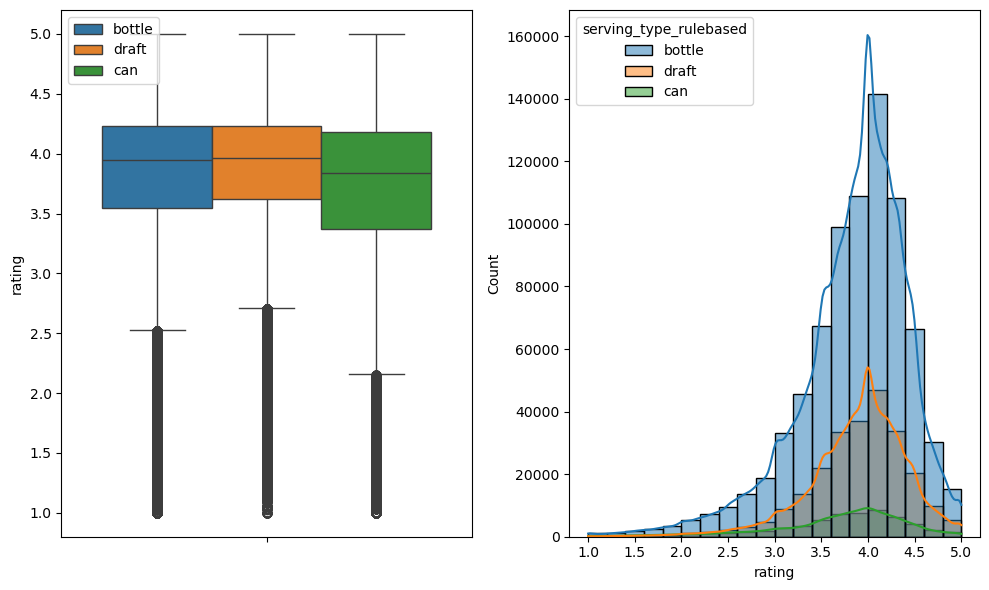

In [72]:
# show boxplot and histograms of ratings for bottle, can and draft
plt.figure(figsize=(10, 6))
plt.subplot(121)
sns.boxplot(data=df, hue='serving_type_rulebased', y='rating')
plt.legend(loc='upper left')
plt.subplot(122)
sns.histplot(data=df, hue='serving_type_rulebased', x='rating', kde=True, bins=20)
plt.tight_layout()
plt.show()

## 5. Statistical Analysis 📈

### 5.1 Measure the impact of each aspect on rating 📏
> First draft analysis to look which aspect has more impact on the rating. We will continue this analysis in P3.

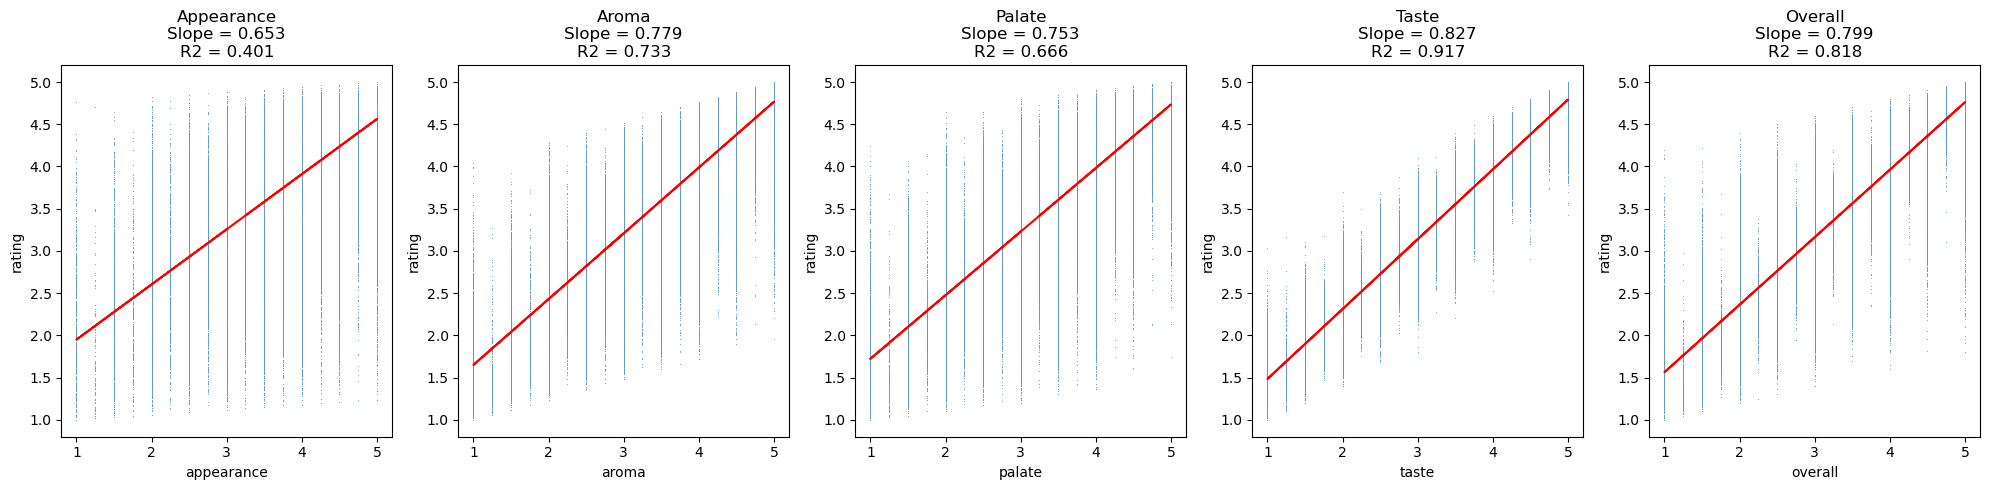

In [73]:
# fit a linear regression line to the data for all 5 aspects
reg1 = LinearRegression().fit(df[['appearance']], df['rating'])
reg2 = LinearRegression().fit(df[['aroma']], df['rating'])
reg3 = LinearRegression().fit(df[['palate']], df['rating'])
reg4 = LinearRegression().fit(df[['taste']], df['rating'])
reg5 = LinearRegression().fit(df[['overall']], df['rating'])

# create subplots for all 5 aspects
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# plot the data and regression line for each aspect
sns.scatterplot(data=df, x='appearance', y='rating', s=0.5, ax=axs[0])
axs[0].plot(df[['appearance']], reg1.predict(df[['appearance']]), color='red')
axs[0].set_title('Appearance\nSlope = ' + str(round(reg1.coef_[0], 3)) + '\nR2 = ' + str(round(reg1.score(df[['appearance']], df['rating']), 3)))

sns.scatterplot(data=df, x='aroma', y='rating', s=0.5, ax=axs[1])
axs[1].plot(df[['aroma']], reg2.predict(df[['aroma']]), color='red')
axs[1].set_title('Aroma\nSlope = ' + str(round(reg2.coef_[0], 3)) + '\nR2 = ' + str(round(reg2.score(df[['aroma']], df['rating']), 3)))

sns.scatterplot(data=df, x='palate', y='rating', s=0.5, ax=axs[2])
axs[2].plot(df[['palate']], reg3.predict(df[['palate']]), color='red')
axs[2].set_title('Palate\nSlope = ' + str(round(reg3.coef_[0], 3)) + '\nR2 = ' + str(round(reg3.score(df[['palate']], df['rating']), 3)))

sns.scatterplot(data=df, x='taste', y='rating', s=0.5, ax=axs[3])
axs[3].plot(df[['taste']], reg4.predict(df[['taste']]), color='red')
axs[3].set_title('Taste\nSlope = ' + str(round(reg4.coef_[0], 3)) + '\nR2 = ' + str(round(reg4.score(df[['taste']], df['rating']), 3)))

sns.scatterplot(data=df, x='overall', y='rating', s=0.5, ax=axs[4])
axs[4].plot(df[['overall']], reg5.predict(df[['overall']]), color='red')
axs[4].set_title('Overall\nSlope = ' + str(round(reg5.coef_[0], 3)) + '\nR2 = ' + str(round(reg5.score(df[['overall']], df['rating']), 3)))

plt.tight_layout()
plt.show()

# should still add confidence intervals

> It seems like Taste as the biggest impact on the rating while appearance has the least impact.

### 5.2 Hypothesis testing on the new labels

In [74]:
def do_ttest(type1, type2, category):
    ttest = ttest_ind(df[df['serving_type_rulebased'] == type1][category],df[df['serving_type_rulebased'] == type2][category])
    if ttest[1] > 0.05:
        print('The p-value is high (' + str(ttest[1]) + '), so we cannot reject the null hypothesis that the two samples have the same average')
    else:
        print('The p-value is very low (' + str(ttest[1]) + '), so we can reject the null hypothesis that the two samples have the same average')

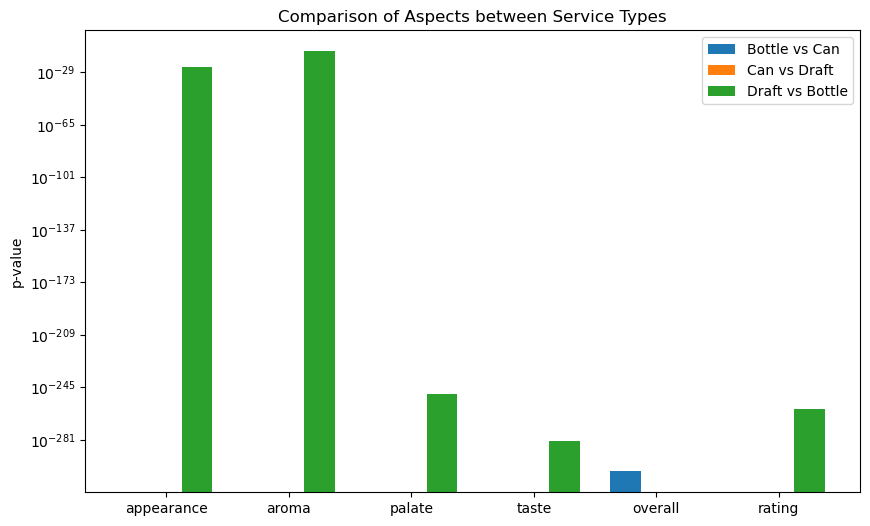

In [75]:
# define the columns to compare
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

# create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(df[df['serving_type_rulebased'] == 'bottle'][columns[i]], df[df['serving_type_rulebased'] == 'can'][columns[i]])
    ttest2 = ttest_ind(df[df['serving_type_rulebased'] == 'can'][columns[i]], df[df['serving_type_rulebased'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(df[df['serving_type_rulebased'] == 'draft'][columns[i]], df[df['serving_type_rulebased'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, p_values[:,0], width, label='Bottle vs Can')
rects2 = ax.bar(x, p_values[:,1], width, label='Can vs Draft')
rects3 = ax.bar(x + width, p_values[:,2], width, label='Draft vs Bottle')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(columns)
ax.set_ylabel('p-value')
ax.set_title('Comparison of Aspects between Service Types')
ax.legend()
plt.show()

> All the p-values are below 0.05, so we can reject the null hypothesis and conclude that there is a significant difference between the groups.